In [1]:
import pandas as pd
import numpy as np
from google.colab import drive

drive.mount('/content/drive')

train_data = '/content/drive/My Drive/Datasheet/Image Classification/1-9 Classification/train.csv'
test_data  = '/content/drive/My Drive/Datasheet/Image Classification/1-9 Classification/train.csv'

Mounted at /content/drive


In [2]:
train = pd.read_csv(train_data)
test  = pd.read_csv(test_data)

In [9]:
print(train.shape)
print(test.shape)
print(train.columns[:10])
print(test.columns[:10])

(42000, 785)
(42000, 785)
Index(['label', 'pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5',
       'pixel6', 'pixel7', 'pixel8'],
      dtype='object')
Index(['label', 'pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5',
       'pixel6', 'pixel7', 'pixel8'],
      dtype='object')


In [18]:
from tensorflow.keras.utils import to_categorical

# Train
X_train = train.drop('label', axis=1)
y_train = train['label']

# Test
X_test = test.drop('label', axis=1)
y_test = test['label']

# Normalisasi
X_train = X_train / 255.0
X_test = X_test / 255.0

# Reshape
y_train = to_categorical(y_train, num_classes=10)
y_test  = to_categorical(y_test, num_classes=10)

In [19]:
X_train = X_train.values.reshape(-1,28,28,1)
X_test = X_test.values.reshape(-1,28,28,1)

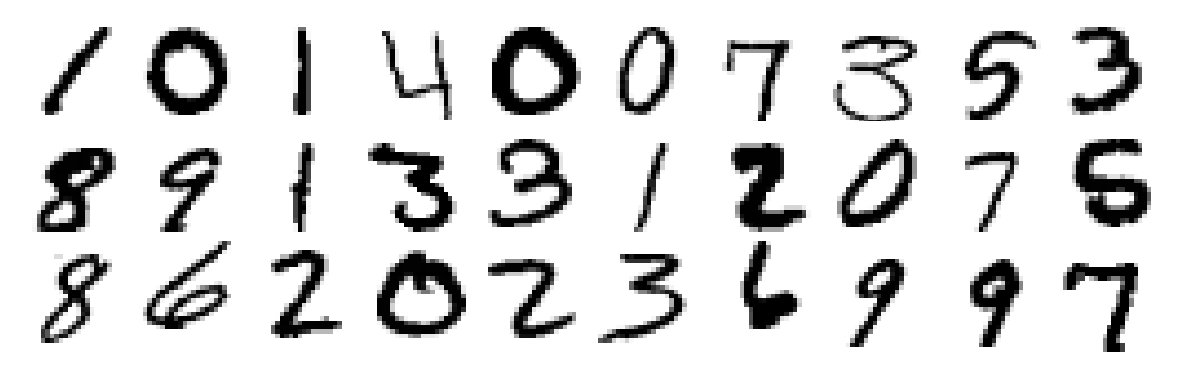

In [22]:
# Preview Images
import matplotlib.pyplot as plt

plt.figure(figsize=(15,4.5))
for i in range(30):
  plt.subplot(3, 10, i+1)
  plt.imshow(X_train[i].reshape((28,28)), cmap=plt.cm.binary)
  plt.axis('off')
plt.subplots_adjust(wspace = -0.1, hspace=-0.1)
plt.show()

In [26]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range = 10,
    zoom_range = 0.10,
    width_shift_range = 0.1,
    height_shift_range = 0.1
)

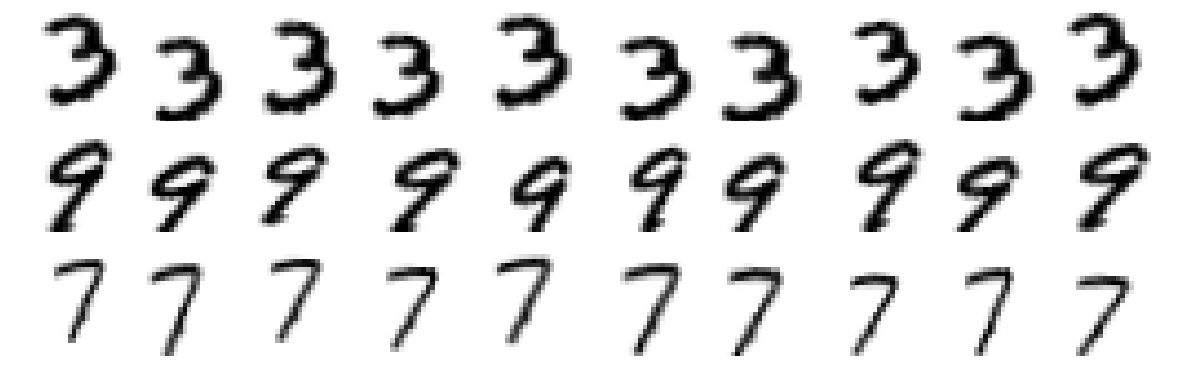

In [29]:
# Preview Augmented Images
X_train3 = X_train[9,].reshape((1,28,28,1))
y_train3 = y_train[9,].reshape((1,10))
plt.figure(figsize=(15,4.5))
for i in range(30):
  plt.subplot(3, 10, i+1)
  X_train2, y_train2 = next(datagen.flow(X_train3, y_train3))
  plt.imshow(X_train2[0].reshape((28,28)), cmap=plt.cm.binary)
  plt.axis('off')
  if i==9: X_train3 = X_train[11, ].reshape((1, 28, 28, 1))
  if i==19: X_train3 = X_train[18,].reshape((1, 28, 28, 1))
plt.subplots_adjust(wspace=-0.1, hspace=-0.1)
plt.show()

In [33]:
!pip install keras-tuner==1.4.6

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 5.2 MB/s eta 0:00:00


In [64]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import keras_tuner as kt

# Build Model dengan Neural Architecture Search
def model_cnn (hp):
  model = models.Sequential()

  # CNN Layer Pertama (Conv2D tetap)
  # Layer pertama menerima input dan layer fix tidak termasuk lagi ke dalam proses NAS
  model.add(layers.Conv2D(
      filters=hp.Int('conv_1_filters', 32, 64, step=32),
      kernel_size = hp.Choice('conv_1_kernel', values=[3,5]),
      activation='relu',
      input_shape=(28,28,1)
  ))
  model.add(layers.MaxPooling2D(pool_size=2))

  # ----- Layer Tambahan (1-3 layer conv opsional)
  for i in range(hp.Int('num_conv_layers', 1,2, step=1)): # NAS akan coba 1-3 layer tambahan
    model.add(layers.Conv2D(
        filters=hp.Int(f'conv_{i+2}_filters', 32, 64, step=32),
        kernel_size=hp.Choice(f'conv_{i+2}_kernel', [3,5]),
        activation=hp.Choice(f'conv_{i+2}_activation', ['relu','elu'])
    ))
    model.add(layers.MaxPooling2D(pool_size=2))

  # ==== Flaten + Dense ====
  model.add(layers.Flatten())
  model.add(layers.Dense(units=hp.Int('dense_units', 32,64, step=32), activation='relu'))
  model.add(layers.Dropout(rate=hp.Float('dropout', 0.2, 0.4, step=0.1)))

  # Output Layers
  model.add(layers.Dense(10,activation='softmax'))

  lr = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=lr), loss='categorical_crossentropy',
      metrics=['accuracy']
  )
  return model

In [65]:
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

tuner = kt.Hyperband(
    model_cnn,
    objective='val_accuracy',
    max_epochs=20,
    factor=3,
    directory='mnist_tuner',
    project_name='cnn_imageclassification',
    overwrite =True
)
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5)
]

In [66]:
tuner.search(
    X_train, y_train,
    validation_split=0.2,
    epochs = 5, # Epochs per trial awal
    callbacks=callbacks
)

Trial 28 Complete [00h 24m 29s]
val_accuracy: 0.9886904954910278

Best val_accuracy So Far: 0.9920238256454468
Total elapsed time: 03h 43m 15s


In [71]:
from sklearn.metrics import accuracy_score, classification_report

# Top 3 Model Terbaik
best_hps = tuner.get_best_hyperparameters(num_trials=3)
best_models = tuner.get_best_models(num_models=3)
print("\n == Top 3 Model Terbaik ==")
for i, (hp,model) in enumerate(zip(best_hps, best_models), start=1):
  # Evaluasi model pada data test
  loss, acc = model.evaluate(X_test, y_test, verbose=0)

  print(f'\nModel {i}:')
  print(f'Validation Accuracy: {acc:.4f}')
  print('Hyperparameters :')
  for param, value in hp.values.items():
    print(f'{param}:{value}')

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))



 == Top 3 Model Terbaik ==

Model 1:
Validation Accuracy: 0.9980
Hyperparameters :
conv_1_filters:32
conv_1_kernel:5
num_conv_layers:2
conv_2_filters:64
conv_2_kernel:5
conv_2_activation:relu
dense_units:64
dropout:0.2
learning_rate:0.001
tuner/epochs:20
tuner/initial_epoch:7
tuner/bracket:2
tuner/round:2
conv_3_filters:32
conv_3_kernel:3
conv_3_activation:relu
tuner/trial_id:0012

Model 2:
Validation Accuracy: 0.9982
Hyperparameters :
conv_1_filters:64
conv_1_kernel:5
num_conv_layers:2
conv_2_filters:64
conv_2_kernel:5
conv_2_activation:relu
dense_units:32
dropout:0.2
learning_rate:0.001
conv_3_filters:32
conv_3_kernel:3
conv_3_activation:elu
tuner/epochs:20
tuner/initial_epoch:7
tuner/bracket:2
tuner/round:2
tuner/trial_id:0014

Model 3:
Validation Accuracy: 0.9946
Hyperparameters :
conv_1_filters:64
conv_1_kernel:5
num_conv_layers:2
conv_2_filters:64
conv_2_kernel:5
conv_2_activation:relu
dense_units:32
dropout:0.2
learning_rate:0.001
conv_3_filters:32
conv_3_kernel:3
conv_3_activa

In [72]:
best_models = tuner.get_best_models(num_models=1)[0]
best_models.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 24, 24, 32)     │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 64)       │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 2, 2, 32)       │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 1, 1, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 73,322 (286.41 KB)

 Trainable params: 73,322 (286.41 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'],label)

In [74]:
 loss, acc = best_models.evaluate(X_test, y_test)

 print(f'Akurasi model terbaik pada data uji:{acc:.4f}')
 print(f'Loss model terbaik pada data uji:{loss:.4f}')

1313/1313 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - accuracy: 0.9994 - loss: 0.0024
Akurasi model terbaik pada data uji:0.9980
Loss model terbaik pada data uji:0.0101


In [78]:
from google.colab import files
best_models.save('classification_image_CNN.h5')
files.download('classification_image_CNN.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>